In [1]:
# Uncomment line below to install exlib
# !pip install exlib

# Mass Maps
This is a notebook for MassMaps. 
The inputs are simulated weak lensing maps of the shape (batch_size, 1, 66, 66). 
The model predicts $\Omega_m$ and $\sigma_8$ from the weak lensing map.

In [3]:
import sys
sys.path.insert(0, "../../src")
import exlib
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsDataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Load Data

In [4]:
# Load data
train_dataset = MassMapsDataset(split="train")
val_dataset = MassMapsDataset(split="validation")
test_dataset = MassMapsDataset(split="test")

### Baselines for getting expert features

In [5]:
# Baselines
from exlib.features.vision.mass_maps import MassMapsOracle, MassMapsOne
from exlib.features.vision.watershed import WatershedGroups
from exlib.features.vision.quickshift import QuickshiftGroups
from exlib.features.vision.patch import PatchGroups

In [6]:
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device)

# Show FIXScores for some examples

In [7]:
import math
import matplotlib.pyplot as plt
from exlib.datasets.mass_maps import MassMapsFixScore

def show_example(groups, X, img_idx=0):
    massmaps_align = MassMapsFixScore().to(device)
    alignment_results = massmaps_align(groups, X, reduce='none', return_dict=True)
    
    m = groups.shape[1]
    cols = 8
    rows = math.ceil(m / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axs = axs.ravel()

    image = X[img_idx]
    for idx in range(len(axs)):
        if idx < m:
            mask = groups[img_idx][idx]

            if mask.sum() > 0:
                axs[idx].imshow(image[0].cpu().numpy())
                axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
                axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                                cmap='gray', extend='neither', linestyles='--', alpha=0.01)

                p_void_ = alignment_results['p_void_']
                p_cluster_ = alignment_results['p_cluster_']
                purity = alignment_results['purity']
                # total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
                axs[idx].set_title(f'void {p_void_[0][idx].item():.5f}\ncluster {p_cluster_[0][idx].item():.5f}\npurity {purity[0][idx].item():.5f}')
        axs[idx].axis('off')
    plt.show()

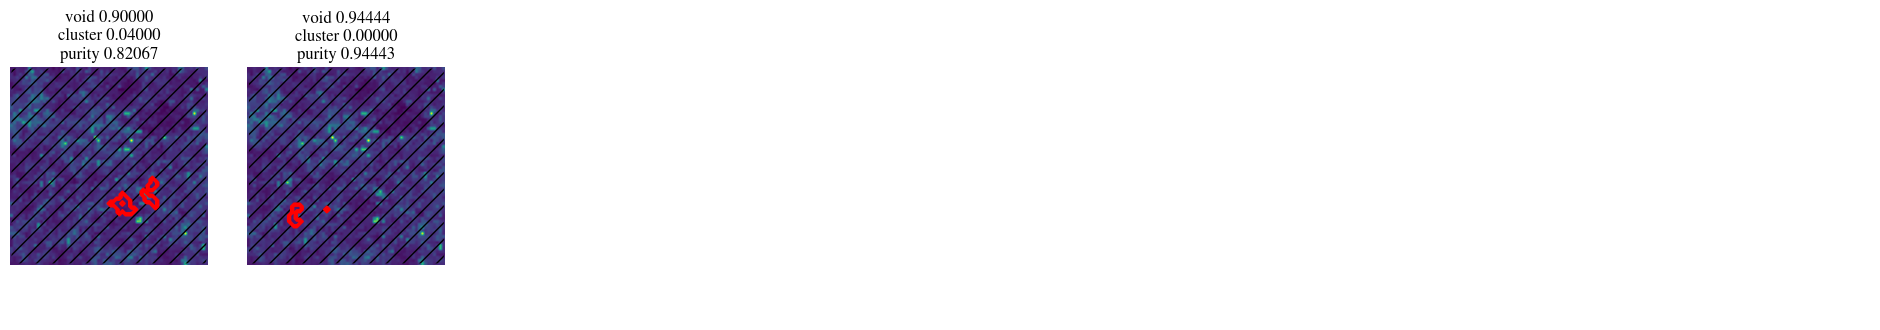

In [8]:
import torch
from exlib.datasets.mass_maps import MassMapsFixScore
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = watershed_baseline(X)
groups_show = torch.stack([groups[0:1,2], groups[0:1,6]], dim=1)
show_example(groups_show, X[0:1])

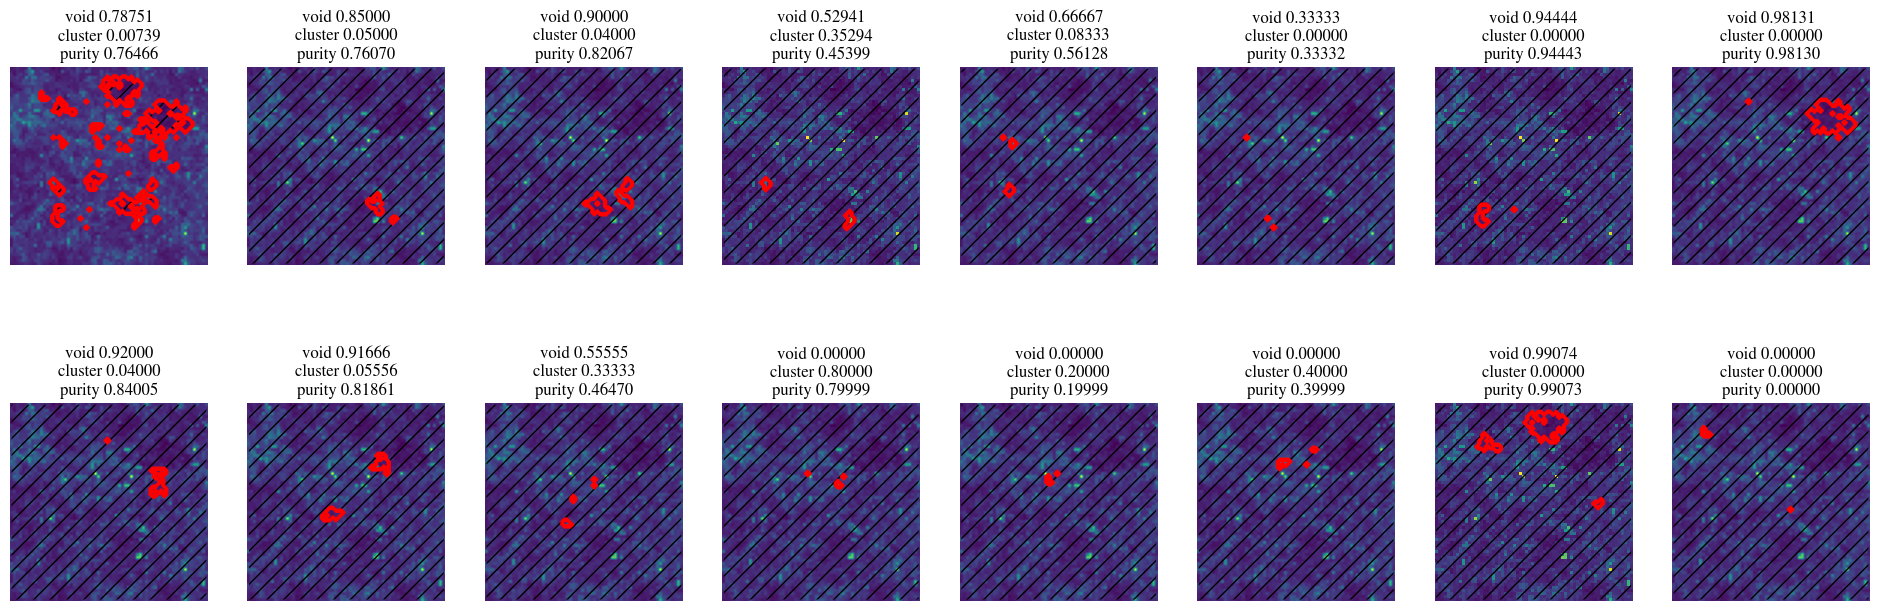

In [9]:
show_example(groups, X)

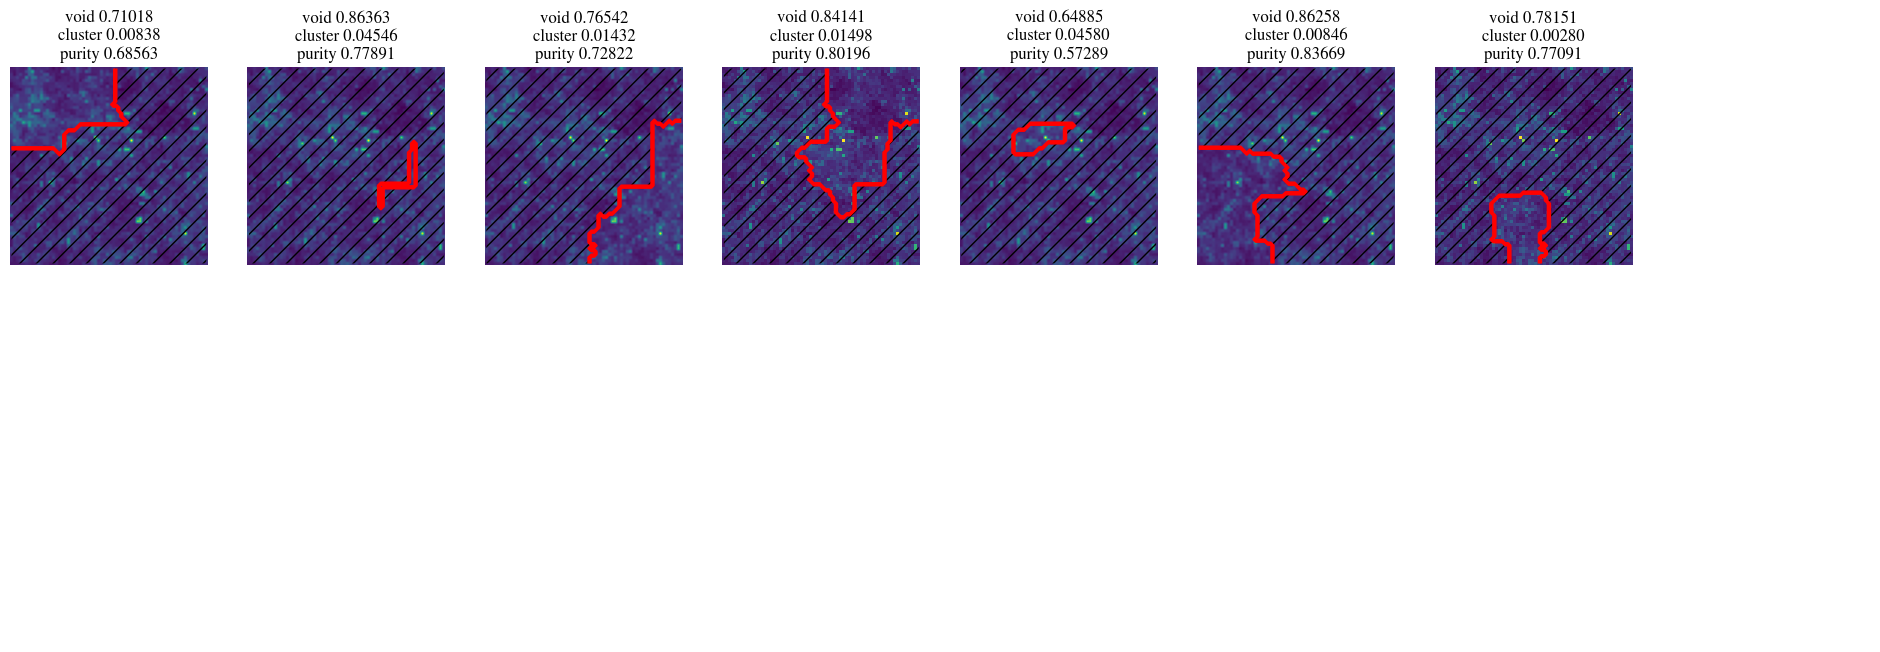

In [10]:
quickshift_baseline = QuickshiftGroups(
    kernel_size=5,
    max_dist=10,
    sigma=5).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = quickshift_baseline(X)
show_example(groups, X)

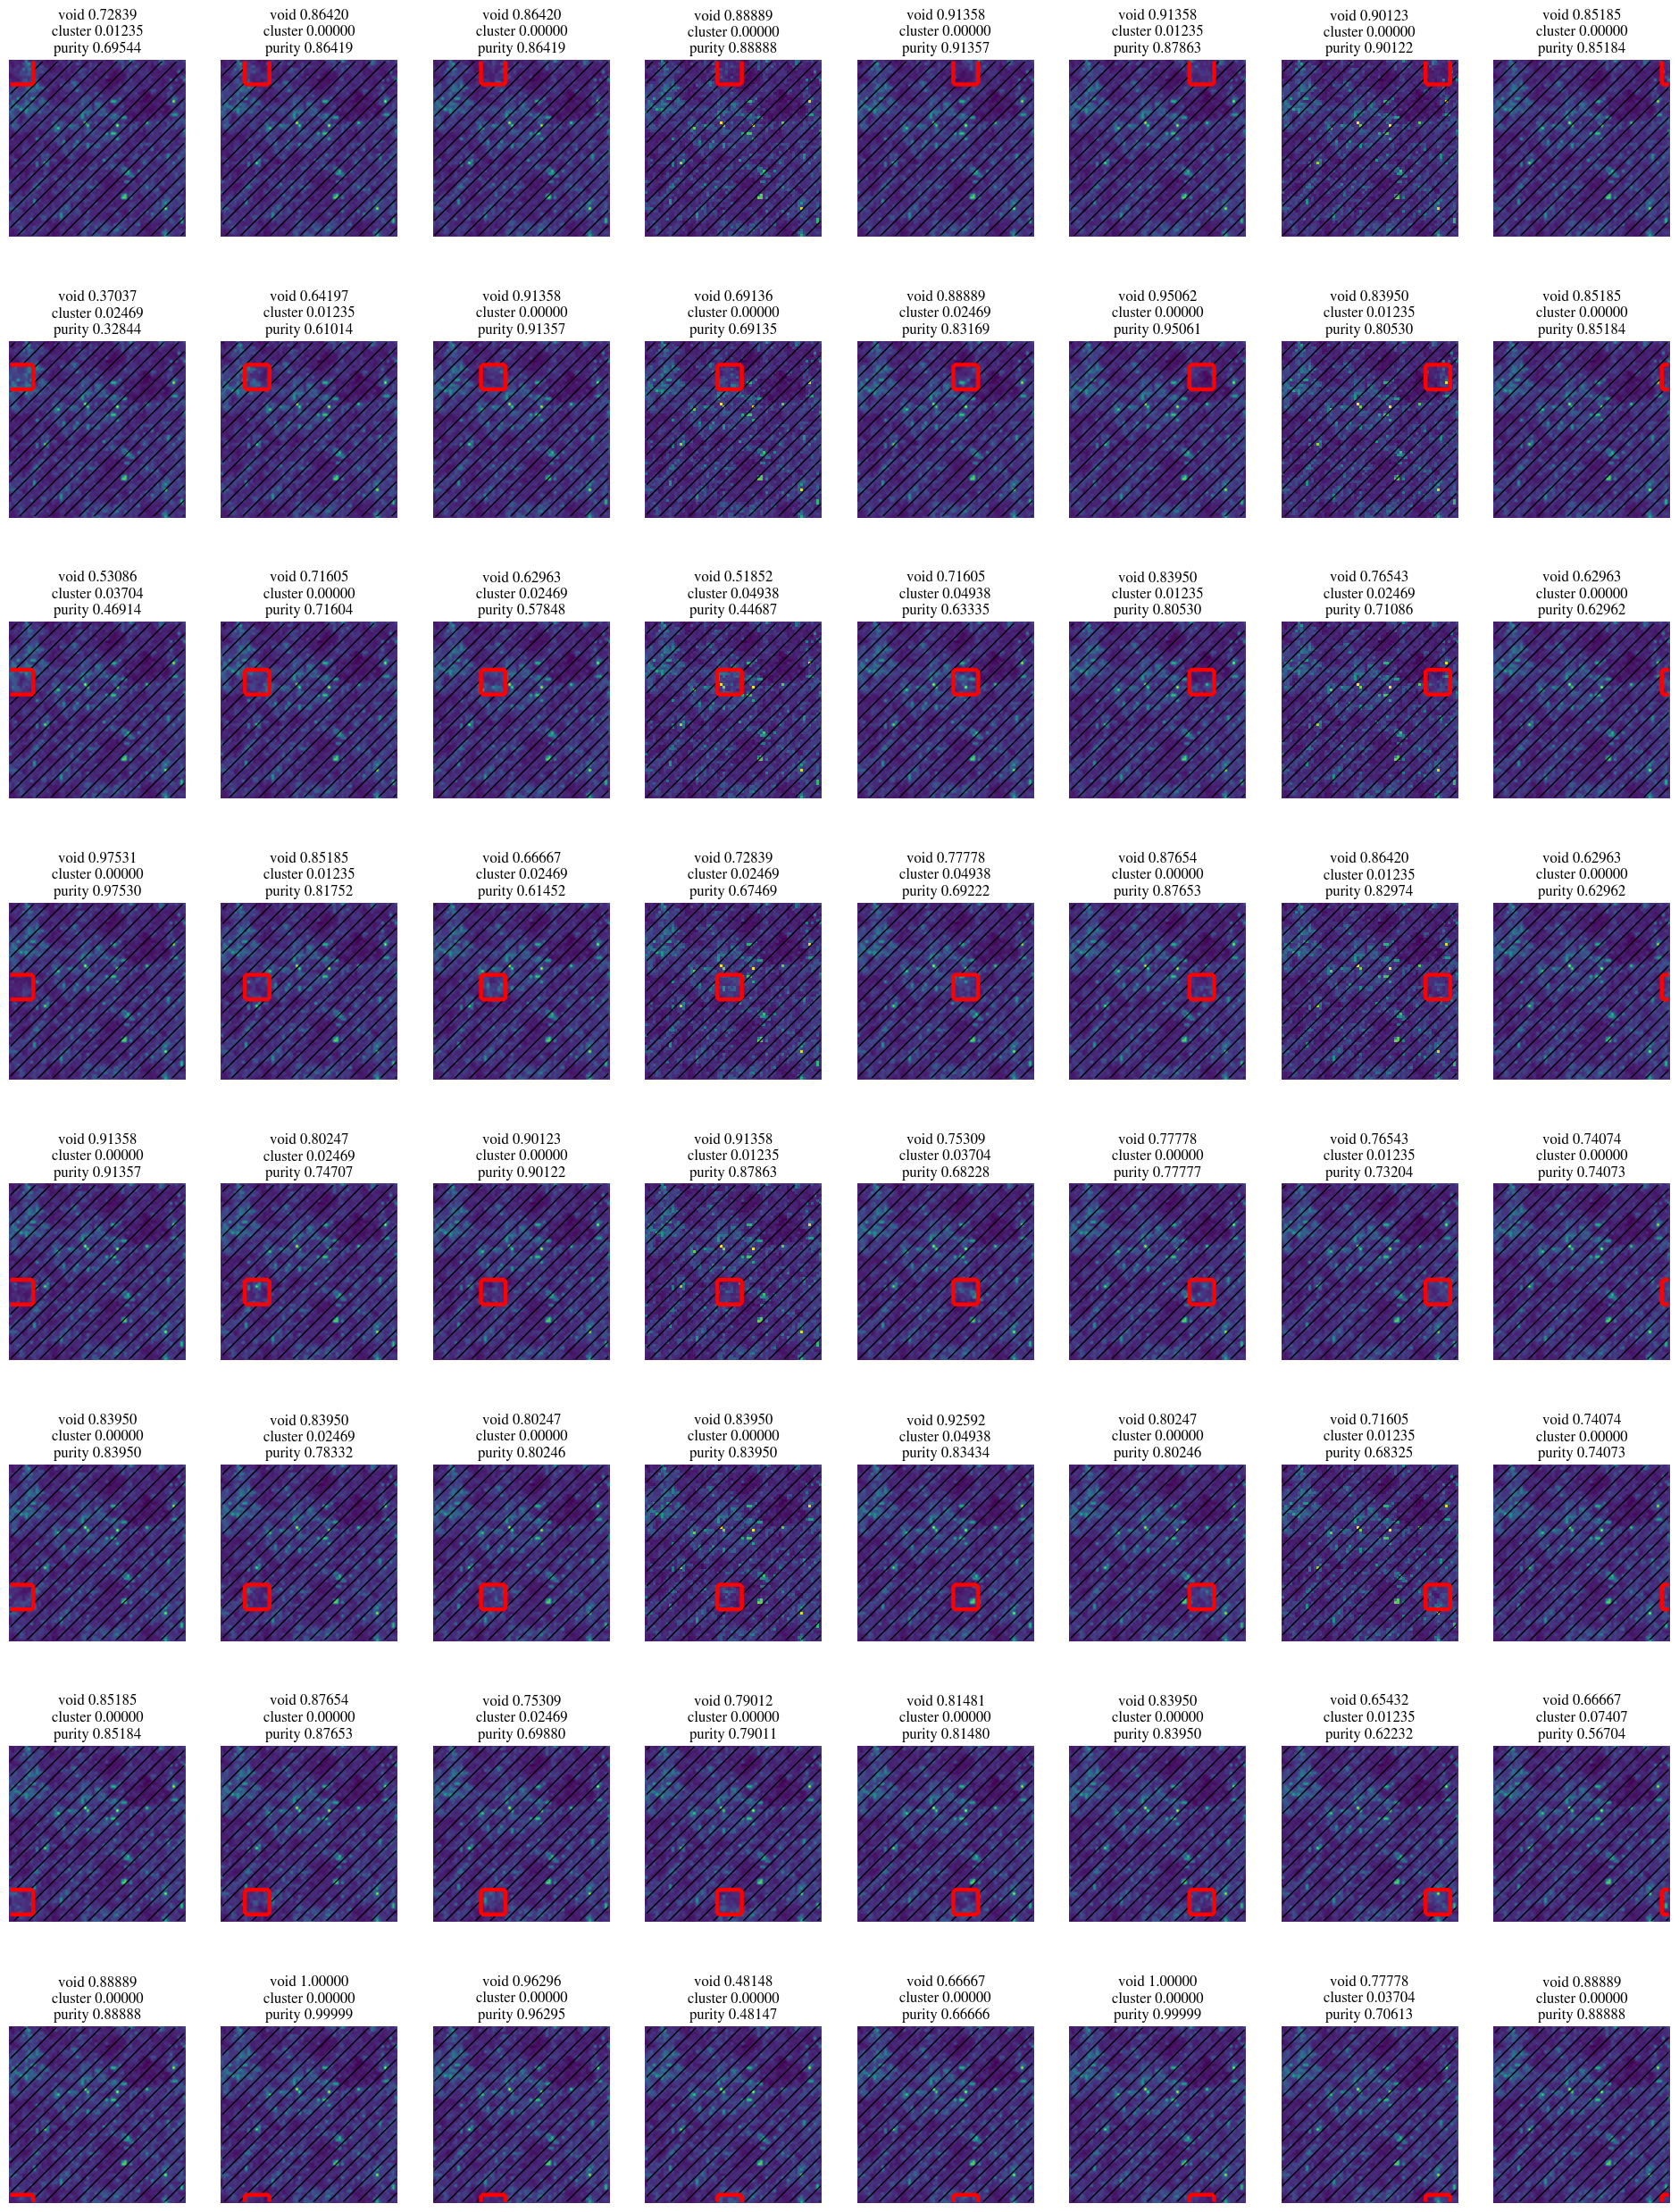

In [11]:
patch_baseline = PatchGroups(grid_size=(8, 8), mode='grid').to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = patch_baseline(X)
show_example(groups, X)

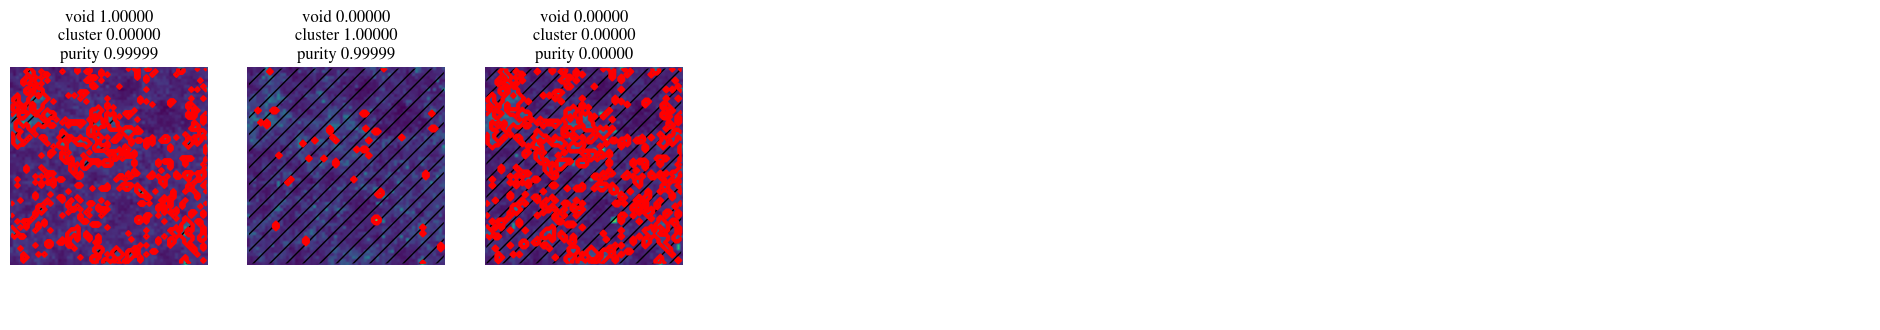

In [12]:
oracle_baseline = MassMapsOracle().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = oracle_baseline(X)
show_example(groups, X)

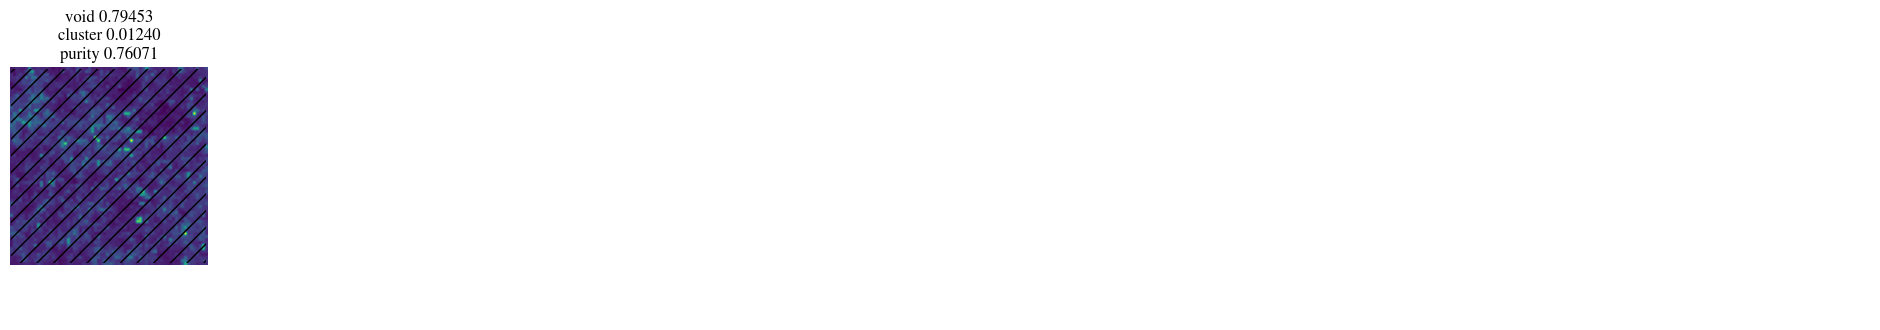

In [13]:
one_baseline = MassMapsOne().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = one_baseline(X)
show_example(groups, X)

# Compare baselines

In [14]:
mass_maps_fixscores = get_mass_maps_scores(subset=True)

pytorch_model.bin:   0%|          | 0.00/793k [00:00<?, ?B/s]

  0%|          | 0/64 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Omega_m loss 0.0053, sigma_8 loss 0.0129, avg loss 0.0091


In [15]:
for name in mass_maps_fixscores:
    metric = torch.tensor(mass_maps_fixscores[name])
    mean_metric = metric.mean()
    print(f'{name}\t{mean_metric.item():.4f}')

identity	0.5427
random	0.5448
patch	0.5499
quickshift	0.5433
watershed	0.5523
sam	0.5472
ace	0.5457
craft	0.4000
archipelago	0.5489


In [16]:
from exlib.features.vision.watershed import WatershedGroups
watershed_baseline = WatershedGroups(min_dist=10, compactness=0)
mass_maps_fixscores_watershed = get_mass_maps_scores(['watershed'], subset=True)

  0%|          | 0/64 [00:00<?, ?it/s]

Omega_m loss 0.0053, sigma_8 loss 0.0129, avg loss 0.0091


In [17]:
torch.mean(mass_maps_fixscores_watershed['watershed'])

tensor(0.5523)

In [26]:
# compute all scores
mass_maps_fixscores = get_mass_maps_scores(subset=False)

  0%|          | 0/64 [00:00<?, ?it/s]

Omega_m loss 0.0049, sigma_8 loss 0.0107, avg loss 0.0078


In [27]:
for name in mass_maps_fixscores:
    metric = torch.tensor(mass_maps_fixscores[name])
    mean_metric = metric.mean()
    print(f'{name}\t{mean_metric.item():.4f}')

identity	0.5483
random	0.5505
patch	0.5555
quickshift	0.5492
watershed	0.5590
sam	0.5521
ace	0.5515
craft	0.3996
archipelago	0.5542


In [28]:
scores_filepath = '../../fix/results/mass_maps/all_baselines_scores.pt'
torch.save(mass_maps_fixscores, scores_filepath)